# Example of *Using* Compact Representations Using Craspy (results from Araya et al, 2018)

### Mauricio Araya (1), Diego Mardones (2), Marcelo Mendoza (1), Mauricio Solar (1) and Amelia Bayo (3)

(1) Universidad Técnica Federico Santa María <br>
(2) Universidad de Chile <br>
(3) Universidad de Valparaíso

# 1. Introduction

This notebook contains the code for replicating the experiments presented in the paper "Homogeneous Representations of Spectroscopic Data Cubes".

### Imports and Initialization

In [1]:
#matplotlib qt
%matplotlib inline

import craspy

### Downloading Data
Our data set is composed by a few spectroscopic cubes from the [ALMA Science Verification Dataset](https://almascience.nrao.edu/alma-data/science-verification). The following code download, uncompress and rename the files for its use.
Please note that this code does not download de data again if it is found (was downloaded for example en part 1)

In [2]:
import os
import urllib.request
import tarfile
from shutil import copyfile

DOWNLOADS_DIR = 'data/'

# Data from ALMA science verification 

# URLs of the tarballs
urls  = ['https://almascience.nrao.edu/almadata/sciver/OrionKLBand6/OrionKL_Band6_ReferenceImages.tgz',
         'https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz',
         'https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz',
         #'https://bulk.cv.nrao.edu/almadata/sciver/AntennaeBand7/Antennae_Band7_ReferenceImages.tgz',
         'https://almascience.nrao.edu/almadata/sciver/IRAS16293Band6/IRAS16293_Band6_ReferenceImages.tgz']

# Fits names and their "fantasy" names 
flist  = [('Orion.methanol.cbc.contsub.image.fits',          'Orion-CH3OH'),
          ('TWHydra_CO3_2line.image.fits',                   'TWHydra-CO3_2'),
          ('M100line.image.fits',                            'M100-CO1_0'),
          #('Antennae_North.CO3_2Line.Clean.pcal1.image.fits','AntennaeN-CO3_'),
          ('I16293_220GHzcorrected.ms.selfcube.image.fits',  'IRAS16293-2422-HCOCH')]

fits_map=dict(zip(urls, flist))

for url,ffile in fits_map.items():
    # Split on the rightmost / and take everything on the right side of that
    name = url.rsplit('/', 1)[-1]
    # Combine the name and the downloads directory to get the local filename
    filename = os.path.join(DOWNLOADS_DIR, name)
    if not os.path.isfile(filename):
        print("Downloading "+str(url))
        urllib.request.urlretrieve(url, filename)
    else:
        print("File found, skipping download of "+str(url))
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    #print(sdir)
    if not os.path.isdir(sdir):
        print("Uncompressing "+str(filename))
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()
    else:
        print("Directory "+str(sdir)+ " found, not uncompressing")
    copyfile(sdir+"/"+ffile[0], DOWNLOADS_DIR+"/"+ffile[0])
    

File found, skipping download of https://almascience.nrao.edu/almadata/sciver/OrionKLBand6/OrionKL_Band6_ReferenceImages.tgz
Directory data/OrionKL_Band6_ReferenceImages found, not uncompressing
File found, skipping download of https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz
Directory data/TWHYA_BAND7_ReferenceImages found, not uncompressing
File found, skipping download of https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz
Directory data/M100_Band3_ReferenceImages found, not uncompressing
File found, skipping download of https://almascience.nrao.edu/almadata/sciver/IRAS16293Band6/IRAS16293_Band6_ReferenceImages.tgz
Directory data/IRAS16293_Band6_ReferenceImages found, not uncompressing


### Load Data from part 1

In [3]:

from astropy.nddata import NDData
from astropy.io import ascii,fits
ghr_table=ascii.read("GHR-Summary.dat")
phr_table=ascii.read("PHR-Summary.dat")
snr_table=ascii.read("SNR-Summary.dat")
summary=ascii.read("Data-Summary.dat")
rep_list=[]
syn_list=[]
resi_list=[]
for i in range(len(flist)):
    ffile=flist[i]
    name=ffile[1]
    rep_list.append(ascii.read("REP-"+name+".dat"))
    cube=craspy.load_ALMA_fits("SYN-"+name+".fits")    
    syn_list.append(cube.data)
    cube=craspy.load_ALMA_fits("RES-"+name+".fits")    
    resi_list.append(cube.data)

INFO: Processing PrimaryHDU Object 0 [craspy.fits]


INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]


INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]


In [4]:
ghr_table

Name,RMS,SNR,Pts,Pts/Bound,Pts/Phr,Pts/Valid
str20,float64,float64,int64,float64,float64,float64
Orion-CH3OH,2.607718957793632e-06,1.01,7026,0.1048922861024439,0.12554499320992066,0.01713658536585366
TWHydra-CO3_2,8.994790676787981e-07,1.1179999999999999,1550,0.059961315280464215,0.06513699781475878,0.0013135593220338984
M100-CO1_0,9.180942279785339e-08,1.592,12098,0.11676817203470807,0.11873705699339478,0.001453641360794795
IRAS16293-2422-HCOCH,5.8952157086025623e-08,1.41,34513,0.09912999520334101,0.10520427852476856,0.0027634453027915503


In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['axes.formatter.limits']=(-5,5)
def fmt(x, pos):
    return '{:.1e}'.format(x)
import numpy as np

# 5. Applications of the representation
# 5.1 Orion-KL
Load Orion-KL example, and compute $\sigma$, $\Delta$ and the mould Gaussian. Also arange the GHR as a `numpy.ndarray` and computes the moment0 of the cube (for visualization purposes)

In [6]:
from craspy.homogen import precision_from_delta,create_mould,synthesize_bubbles


ffile        = flist[0]
orig         = craspy.load_ALMA_fits(DOWNLOADS_DIR+ffile[0])
target       = ffile[1]
(orig,ym,yf) = craspy.standarize(orig)
orig2D       = craspy.moment0(orig)
noise        = snr_table['RMS'][0]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[0]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T


INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


### Vertical Flux Decomposition function

In [19]:
def vertical_flux_decomposition(rep,m,shape,mould,noise,delta):
    n_rep=int(len(rep)/m)
    img_list=[]
    vmax=0
    for i in range(m):
        synNew=np.zeros(shape)
        ini=n_rep*i
        end=n_rep*(i+1) - 1
        p_rep=rep[ini:end]
        synthesize_bubbles(synNew,p_rep,mould,noise,delta)
        img=synNew.sum(axis=(0))
        vmax=max(vmax,img.max())
        img_list.append(img)
    return img_list,vmax

### Grid Visualization function

In [20]:

def show_decomposition_grid(img_list,side,vmax):
    cmap="jet"
    origin="lower"

    plt.figure()
    gs = gridspec.GridSpec(side, side,wspace=0.0, hspace=0.0)
    for i in range(side*side):
        ax  = plt.subplot(gs[i])
        ax.imshow(img_list[i],origin=origin,vmax=vmax,vmin=0,cmap=cmap)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

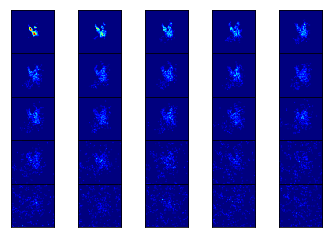

In [21]:
side=5
img_list,vmax=vertical_flux_decomposition(rep,side*side,orig.data.shape,mould,noise,delta)
show_decomposition_grid(img_list,side,vmax)

Threshold representation up to the 15th level and print it

In [22]:
import matplotlib.pyplot as plt

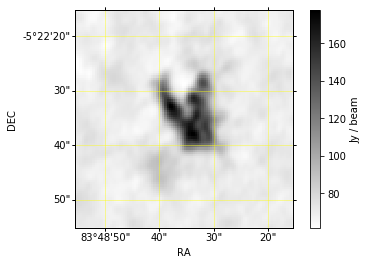

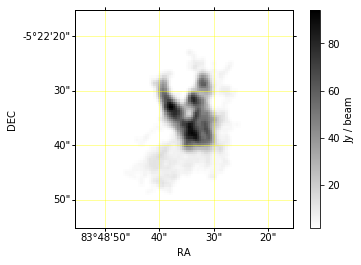

8430


In [25]:

limit  = 10*int(rep.shape[0]/(side*side))
th_rep = rep[0:limit]
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,th_rep,mould,noise,delta)
#print(noise)
img    = synNew.sum(axis=(0))
plt.figure()
craspy.visualize_image(orig2D.data*ym - yf,wcs=orig2D.wcs,unit=orig2D.unit,cmap=plt.cm.gray_r)
plt.figure()
craspy.visualize_image(img*ym-yf,wcs=orig2D.wcs,unit=orig2D.unit,cmap=plt.cm.gray_r)
print(th_rep.size)

In [26]:
def show_clusters(labels,sol,start,stop,shape,template,mould,noise,delta):
    if start is None:
        start=0
    nclus=labels.max()+1
    if stop is None:
        stop=nclus+1
    print("Number of Clusters = "+str(nclus))
    fig=plt.figure(figsize=(5,4))
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[shape[2]/shape[0], 1], height_ratios=[shape[1]/shape[0],1])
    
    tempXY=template.sum(axis=(0))
    #nax=fig.add_subplot(2,3,1)
    nax=plt.subplot(gs[0])
    nax.imshow(tempXY, origin='lower',cmap=plt.cm.gray_r)
    nax.get_xaxis().set_visible(False)
    nax.get_yaxis().set_visible(False)
 
    tempXZ=template.sum(axis=(1))
    #nax2=fig.add_subplot(2,3,4)
    nax2=plt.subplot(gs[2])
    nax2.imshow(tempXZ, origin='lower',cmap=plt.cm.gray_r)
    nax2.get_xaxis().set_visible(False)
    nax2.get_yaxis().set_visible(False)
   
    tempYZ=template.sum(axis=(2)).T
    #nax3=fig.add_subplot(2,3,2)
    nax3=plt.subplot(gs[1])
    nax3.imshow(tempYZ, origin='lower',cmap=plt.cm.gray_r)
    nax3.get_xaxis().set_visible(False)
    nax3.get_yaxis().set_visible(False)
    
    mmask=(labels>-1)
    labels=labels[mmask]
    sol=sol[mmask]
    bco=np.bincount(labels)
    bco=bco.argsort()[::-1][start:stop]
    color=plt.cm.rainbow(np.linspace(0,1,stop-start))
    
    i=0
    for b in bco:
        imask=(labels==b)
        npos  = sol[imask]
        newSyn=np.zeros(shape)
        newSyn=synthesize_bubbles(newSyn,npos,mould,noise,delta)
        nax.contour(newSyn.sum(axis=(0)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax2.contour(newSyn.sum(axis=(1)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax3.contour(newSyn.sum(axis=(2)).T,levels=[0.0],alpha=1.0,colors=[color[i]])
        i+=1
    plt.tight_layout()
    plt.show()
    plt.figure()
    
    #nax4=fig.add_subplot(1,3,3)
    nax4=plt.subplot(111)
    i=0
    for b in bco:
        imask=(labels==b)
        npos  = sol[imask]
        newSyn=np.zeros(shape)
        newSyn=synthesize_bubbles(newSyn,npos,mould,noise,delta)
        nax.contour(newSyn.sum(axis=(0)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax2.contour(newSyn.sum(axis=(1)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax3.contour(newSyn.sum(axis=(2)).T,levels=[0.0],alpha=1.0,colors=[color[i]])
        nax4.plot(newSyn.sum(axis=(1,2)),color=color[i])
        i+=1
    plt.tight_layout()
    plt.show()
    return(bco)

In [27]:
from sklearn.cluster import *
#clust=AffinityPropagation(damping=0.878).fit(th_rep)
#clust=MeanShift(bandwidth=).fit(th_rep)
clust=SpectralClustering(n_clusters=5,gamma=0.5).fit(th_rep)

/Users/mauricio/anaconda3/envs/adassws/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


Number of Clusters = 5


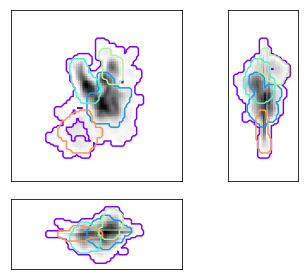

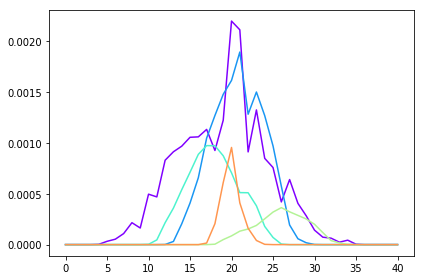

array([1, 3, 0, 2, 4])

In [28]:
show_clusters(clust.labels_,th_rep,None,None,orig.data.shape,synNew,mould,noise,delta)

## 5.2. TWHydra


In [31]:
ffile        = flist[1]
orig         = craspy.load_ALMA_fits(DOWNLOADS_DIR+ffile[0])
target       = ffile[1]
(orig,ym,yf) = craspy.standarize(orig)
orig2D       = craspy.moment0(orig)
noise        = snr_table['RMS'][0]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[1]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [32]:
clust=MeanShift().fit(rep)
#imask=(clust.labels_==0)
#rep_fp=rep[imask]
#clust2=MeanShift().fit(rep_fp)

Number of Clusters = 19


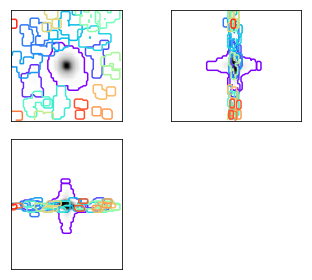

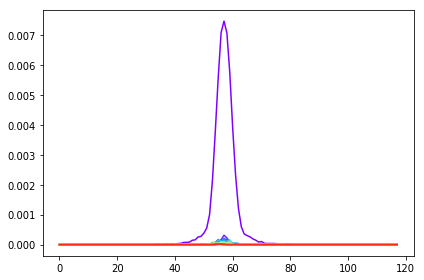

In [33]:
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,rep,mould,noise,delta)
order=show_clusters(clust.labels_,rep,None,None,orig.data.shape,synNew,mould,noise,delta)

In [34]:
newRep=np.ndarray((0,3))
imask=(clust.labels_==order[0])
newRep=np.vstack((newRep,rep[imask]))

In [37]:
from mpl_toolkits.mplot3d import Axes3D

def show_manifold(sm):
    cbook=sm.codebook.matrix
    fig=plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cbook[:,0],cbook[:,1], cbook[:,2])#, c=c, marker=m)
    for cb,dm_elm in zip(cbook,sm._distance_matrix):
        #print(cb)
        conn=(dm_elm==1).nonzero()
        #print(conn[0])
        for idx in conn[0]:
            #print(idx)
            ot=cbook[idx]
            #print(ot)
            ax.plot([cb[0],ot[0]],[cb[1],ot[1]],[cb[2],ot[2]],color = 'g')
    plt.show()

### SOMPY
Here you need to install `sompy` using pip, because there is no conda package (`pip install sompy`)

In [42]:

from sompy.sompy import SOMFactory
sm = SOMFactory().build(newRep, normalization = 'var', initialization='pca')
sm.train(n_job=1, verbose=False, train_rough_len=30, train_finetune_len=30)


ImportError: cannot import name 'SOM'

In [43]:
%matplotlib notebook
show_manifold(sm)

NameError: name 'sm' is not defined

## 5.3. M100


In [45]:
%matplotlib inline
ffile        = flist[2]
orig         = craspy.load_ALMA_fits(DOWNLOADS_DIR+ffile[0])
target       = ffile[1]
(orig,ym,yf) = craspy.standarize(orig)
orig2D       = craspy.moment0(orig)
noise        = snr_table['RMS'][0]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[2]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


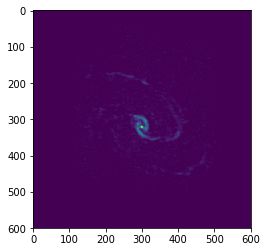

In [46]:
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,rep,mould,noise,delta)
plt.figure()
plt.imshow(synNew.sum(axis=(0)))

Number of Clusters = 87


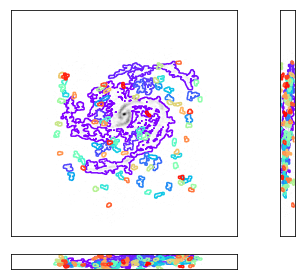

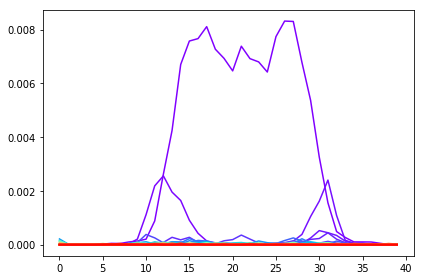

In [47]:
clust=DBSCAN(eps=7.0).fit(rep)
order=show_clusters(clust.labels_,rep,None,None,orig.data.shape,synNew,mould,noise,delta)

Number of Clusters = 87


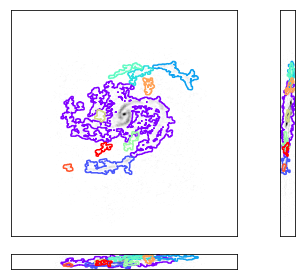

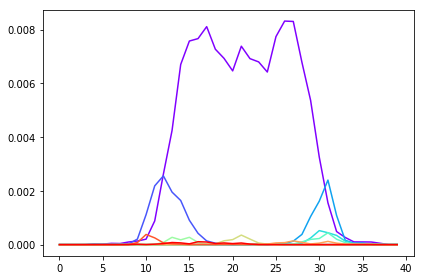

In [48]:
ccut=10
order=show_clusters(clust.labels_,rep,None,ccut,orig.data.shape,synNew,mould,noise,delta)
newRep=np.ndarray((0,3))
for i in range(ccut):
    imask=(clust.labels_==order[i])
    #print(newRep.shape,rep[imask].shape)
    newRep=np.vstack((newRep,rep[imask]))

Number of Clusters = 50


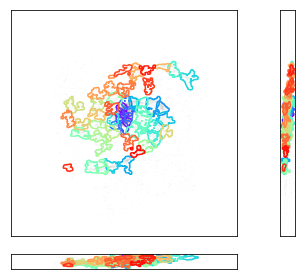

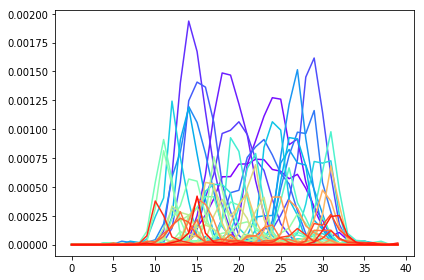

array([ 6, 21, 48, 47, 34, 40, 15, 13, 35, 49, 19,  8,  7, 10, 43,  2, 16,
        0,  1, 26,  5, 37, 27, 24, 17, 23, 39, 36,  9, 20, 32, 29, 14, 18,
       30,  4, 33, 41, 38, 25,  3, 28, 46, 44, 42, 11, 31, 12, 22, 45])

In [49]:
clust=KMeans(n_clusters=50).fit(newRep)
show_clusters(clust.labels_,newRep,None,None,orig.data.shape,synNew,mould,noise,delta)

In [54]:
def row_col_from_condensed_index(d,i):
    b = 1 -2*d 
    x = np.floor((-b - np.sqrt(b**2 - 8*i))/2)
    y = i + x*(b + x + 2)/2 + 1
    return (int(x),int(y))  

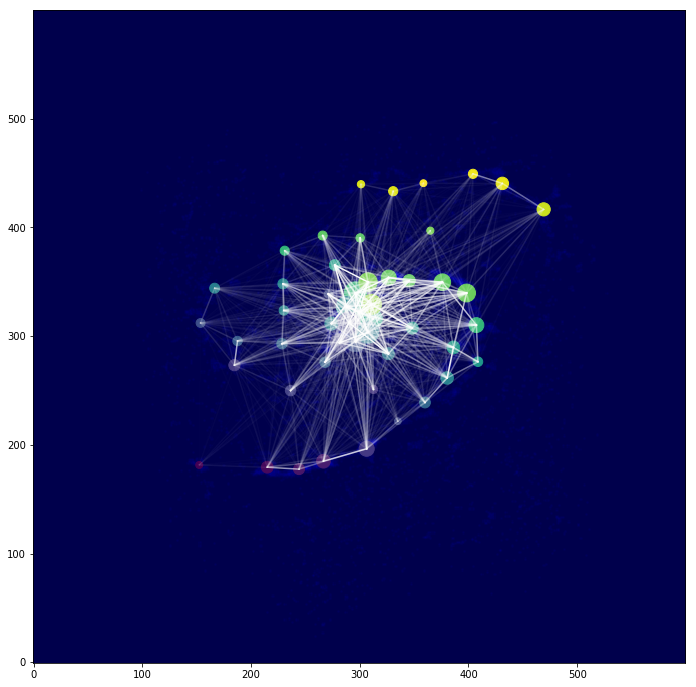

In [61]:
ss=np.bincount(clust.labels_)
ms=ss.max()
from scipy.spatial.distance import pdist,squareform
pps=clust.cluster_centers_
dds=pdist(pps)
dm=dds.max()
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(synNew.sum(axis=(0)),origin='lower',cmap='seismic')
ax.scatter(pps[:,2],pps[:,1],c=pps[:,0],s=ss)#, c=c, marker=m)
k=0
for con in dds:
    (i,j)=row_col_from_condensed_index(pps.shape[0],k)
    if i==j:
        continue
    cb=pps[i]
    ot=pps[j]
    d=con/dm
    mi=ss[i]/ms
    mj=ss[j]/ms
    metr=mi*mj/(d*d)*0.05
    ax.plot([cb[2],ot[2]],[cb[1],ot[1]], alpha = metr,color="white")
    k+=1

## 5.4. IRAS

In [62]:
ffile        = flist[3]
orig         = craspy.load_ALMA_fits(DOWNLOADS_DIR+ffile[0])
target       = ffile[1]
(orig,ym,yf) = craspy.standarize(orig)
orig2D       = craspy.moment0(orig)
noise        = snr_table['RMS'][3]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[3]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [63]:
def show_clusters2(labels,sol,start,stop,shape,template,mould,noise,delta):
    if start is None:
        start=0
    nclus=labels.max()+1
    if stop is None:
        stop=nclus+1
    print("Number of Clusters = "+str(nclus))
    fig=plt.figure(figsize=(5,4))
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[shape[2]/shape[0], 1], height_ratios=[shape[1]/shape[0],1])
    
    tempXY=template.sum(axis=(0))
    #nax=fig.add_subplot(2,3,1)
    nax=plt.subplot(gs[0])
    nax.imshow(tempXY, origin='lower',cmap=plt.cm.gray)
    nax.get_xaxis().set_visible(False)
    nax.get_yaxis().set_visible(False)
 
    tempXZ=template.sum(axis=(1))
    #nax2=fig.add_subplot(2,3,4)
    nax2=plt.subplot(gs[2])
    nax2.imshow(tempXZ, origin='lower',cmap=plt.cm.gray)
    nax2.get_xaxis().set_visible(False)
    nax2.get_yaxis().set_visible(False)
   
    tempYZ=template.sum(axis=(2)).T
    #nax3=fig.add_subplot(2,3,2)
    nax3=plt.subplot(gs[1])
    nax3.imshow(tempYZ, origin='lower',cmap=plt.cm.gray)
    nax3.get_xaxis().set_visible(False)
    nax3.get_yaxis().set_visible(False)
    
    mmask=(labels>-1)
    labels=labels[mmask]
    sol=sol[mmask]
    bco=np.bincount(labels)
    bco=bco.argsort()[::-1][start:stop]
    color=plt.cm.rainbow(np.linspace(0,1,stop-start))
    
    nax4=plt.subplot(gs[3])
    
    i=0
    for b in bco:
        imask=(labels==b)
        npos  = sol[imask]
        newSyn=np.zeros(shape)
        newSyn=synthesize_bubbles(newSyn,npos,mould,noise,delta)
        nax.contour(newSyn.sum(axis=(0)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax2.contour(newSyn.sum(axis=(1)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax3.contour(newSyn.sum(axis=(2)).T,levels=[0.0],alpha=1.0,colors=[color[i]])
        nax4.plot(newSyn.sum(axis=(1,2)),color=color[i])
        i+=1
    plt.tight_layout()
    plt.show()
    return(bco)

Number of Clusters = 69


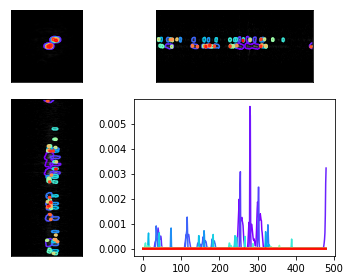

In [64]:
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,rep,mould,noise,delta)
clust=DBSCAN(eps=1.5).fit(rep)
order=show_clusters2(clust.labels_,rep,None,None,orig.data.shape,synNew,mould,noise,delta)

In [65]:
db_rep=rep[clust.labels_!=-1]
print(rep.shape)
print(db_rep.shape)

(34513, 3)
(8596, 3)


Number of Clusters = 100


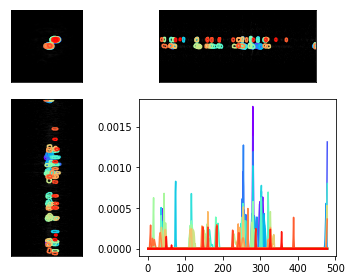

In [66]:
from sklearn.mixture import GaussianMixture
from astropy import units as u
ncomp=100
model=GaussianMixture(n_components=ncomp).fit(db_rep)
labels=model.predict(db_rep)
order=show_clusters2(labels,db_rep,None,None,orig.data.shape,synNew,mould,noise,delta)


In [67]:
def compute_gclumps_parameters(rep,P,cid):
    fwhm_c=np.sqrt(8*np.log(2))
    mu=rep.mean(axis=(0))
    vec=(mu - rep)
    c=rep.size
    Sigma=np.linalg.inv(P)+np.dot(vec.T,vec)/c
    A=np.linalg.inv(Sigma)
    dv=np.sqrt(1./A[0,0])
    ga=-A[2,0]/A[0,0]
    gd=-A[1,0]/A[0,0]
    b0=A[1,1]-(gd*gd)/(dv*dv)
    b1=A[1,2]-(ga*gd)/(dv*dv)
    b2=A[2,2]-(ga*ga)/(dv*dv)
    B=np.linalg.inv(np.array([[b0,b1],[b1,b2]]))
    (U,S,V)=np.linalg.svd(B)
    de=np.sqrt(S)
    return(cid,c,mu[2],mu[1],mu[0],fwhm_c*de[1],fwhm_c*de[0],(np.arcsin(-U[0,0])*u.rad).to("deg").value,fwhm_c*dv,gd,ga)

In [68]:
from astropy.table import Table
gclu=Table(names=('CLUST ID',
                  'N', 
                  'RA',
                  'DEC',
                  'FREQ',
                  'SEMIAXIS 1',
                  'SEMIAXIS 2',
                  'ANGLE',
                  'LINE FWHM',
                  'GRAD RA/FREQ',
                  'GRAD DEC/FREQ'))

for i in order:
    imask=(labels==i)
    rep_gm=db_rep[imask]
    gclu.add_row(vals=compute_gclumps_parameters(rep_gm,P,i))
gclu

CLUST ID,N,RA,DEC,FREQ,SEMIAXIS 1,SEMIAXIS 2,ANGLE,LINE FWHM,GRAD RA/FREQ,GRAD DEC/FREQ
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5.0,612.0,136.73529411764707,126.98039215686275,280.4362745098039,2.9406551254007796,3.7769283149123614,74.03658678649809,1.2837849072761585,0.02684887191838098,-0.013825083824904851
41.0,528.0,119.4659090909091,107.7215909090909,306.1306818181818,3.0882205408749077,3.5057886316168236,70.12320812011667,2.3336314449585176,-0.002409441633255405,-0.010138342899701117
17.0,507.0,111.52071005917159,109.0,299.6213017751479,3.285873216739951,3.549222235553041,-4.897783669624764,2.6411071745914416,0.051772653829398184,-0.15505544716481573
40.0,486.0,131.9506172839506,127.31481481481481,280.58024691358025,2.8541978847437157,4.071434402619656,79.2396532864903,1.3029709492779065,0.03955993411548652,-0.007731276848817505
62.0,441.0,115.19727891156462,107.62585034013605,39.816326530612244,3.16159285450765,3.853334401428783,14.602347457505362,2.7157178954063053,-0.05815829303138037,0.05781320305734858
24.0,435.0,122.80689655172414,109.06206896551724,300.7793103448276,3.315444593397687,3.372834623914717,-39.105684939376545,2.5739763891650864,0.049874473739564794,-0.04192767867426221
78.0,429.0,117.74825174825175,109.94405594405595,298.6013986013986,3.0827243537929485,3.709435759998705,53.16689416323483,2.219850534364222,0.1507980412069828,-0.07676240463297458
0.0,420.0,117.31428571428572,108.20714285714286,256.15,2.835442228739839,3.3849505801163353,89.31071783825757,2.596126990866743,0.16754305761747673,-0.08223311483803133
56.0,405.0,138.26666666666668,127.97037037037038,254.16296296296295,3.156097026286544,3.920033648762845,76.77420187992051,1.5004672950834443,0.002761904522920465,0.07267810368676687


In [69]:
ttab=gclu[gclu['LINE FWHM']>3]
# Generating the latex table for the paper
from astropy.io import ascii
ascii.write(ttab,format='latex')

\begin{table}
\begin{tabular}{ccccccccccc}
CLUST ID & N & RA & DEC & FREQ & SEMIAXIS 1 & SEMIAXIS 2 & ANGLE & LINE FWHM & GRAD RA/FREQ & GRAD DEC/FREQ \\
64.0 & 330.0 & 125.02727272727273 & 107.30909090909091 & 307.8454545454546 & 2.920287185880289 & 3.243725464299823 & 76.96387435028753 & 3.0605014323012596 & -0.08731978181659752 & 0.16890248705941732 \\
86.0 & 285.0 & 119.52631578947368 & 107.50526315789473 & 164.73684210526315 & 2.7607980042242977 & 3.4810072318567613 & -25.093203782749928 & 4.349755824253702 & -0.14840642242162813 & 0.055618080876065006 \\
76.0 & 264.0 & 114.35227272727273 & 108.31818181818181 & 160.10227272727272 & 2.681066786332456 & 3.232819252699088 & -9.440800032716908 & 4.676212610813573 & -0.14977213615925267 & 0.08024992505215976 \\
18.0 & 216.0 & 117.51388888888889 & 108.27777777777777 & 230.86111111111111 & 2.617271173378051 & 3.4987489319822274 & -9.079068307569205 & 4.13526037683162 & -0.1720893088225321 & -0.04289633072463645 \\
20.0 & 201.0 & 118.4477

714
(714, 3)
Number of Clusters = 10


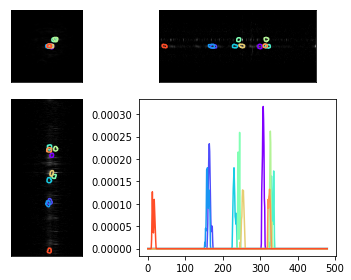

In [70]:
elms=gclu[gclu['LINE FWHM']>3]['CLUST ID']
newRep=np.ndarray((0,3))
newLab=[]
count=0
for j in elms:
    imask=(labels==j)
    current=db_rep[imask]
    newRep=np.vstack((newRep,current))
    newLab.extend([count]*int(current.shape[0]))
    count+=1
print(len(newLab))
print(newRep.shape)
order=show_clusters2(np.array(newLab),newRep,None,None,orig.data.shape,synNew,mould,noise,delta)